In [1]:
import numpy as np
import pandas as pd

from pprint import pprint
from time import time


from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report

In [2]:
data = pd.read_json(r"E:\Sheroo\IBA - MBA\4th Semester\Text Analytics\Final Project\Sarcasm_Headlines_Dataset_v2.json", lines=True)

X_train, X_test, Y_train, Y_test=train_test_split(data['headline'], data['is_sarcastic'], random_state=100,test_size=0.3)

In [ ]:
data.dtypes

In [ ]:
data.isna().sum()

In [3]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


<AxesSubplot:>

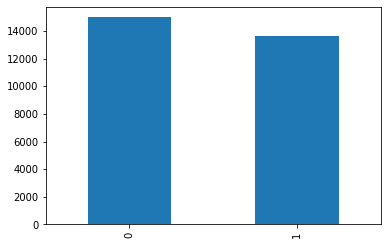

In [5]:
data['is_sarcastic'].value_counts().plot(kind='bar')

In [8]:
data['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

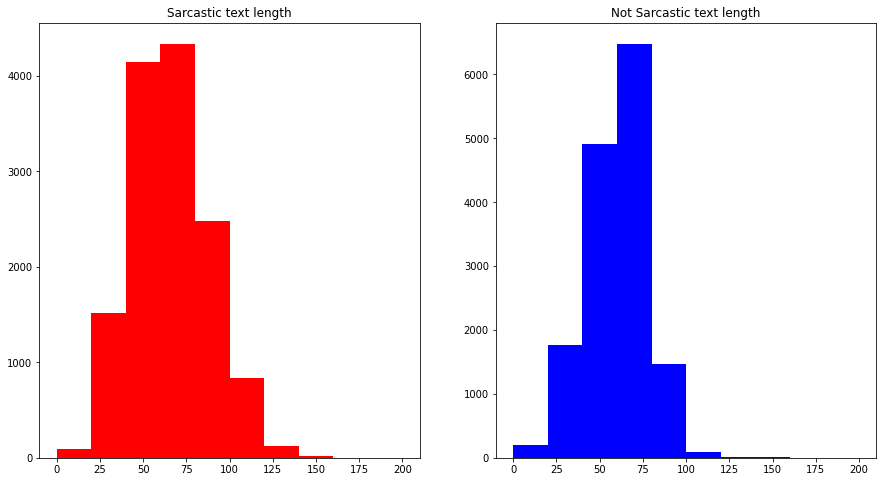

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
text_len=data[data['is_sarcastic']==1]['headline'].drop_duplicates().apply(len)
ax1.hist(text_len,color='red', range=[0, 200])
ax1.set_title('Sarcastic text length')
text_len=data[data['is_sarcastic']==0]['headline'].drop_duplicates().apply(len)
ax2.hist(text_len,color='blue',range=[0, 200])
ax2.set_title('Not Sarcastic text length');

In [ ]:
#Logistic Regression

logreg = LogisticRegression(C=500.0, solver='liblinear').fit(X_train, Y_train)
Y_pred=logreg.predict(X_test)

cm=confusion_matrix(Y_test, Y_pred)
cm_display=ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(values_format="d")

print(classification_report(Y_test, Y_pred, labels=[0, 1]))


In [ ]:
#Random Forest Classifier

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        #("tfidf", TfidfTransformer()),
        ("rfc", RandomForestClassifier())
    ]
)

parameters = {
    "vect__ngram_range": ((1, 1), (1, 2),(1,3),(1,4),(1,5)),
    'rfc__n_estimators': [200,250,300],
    'rfc__max_depth': [65,70,75]
}

grid_search_GB = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)

grid_search_GB.fit(X_train, Y_train)
GB_pred = grid_search_GB.predict(X_test)

print('Boost_Train Accuracy : %.3f'%grid_search_GB.best_estimator_.score(X_train, Y_train))
print('Boost_Test Accuracy : %.3f'%grid_search_GB.best_estimator_.score(X_test, Y_test))
print('Boost_Best Accuracy Through Grid Search : %.3f'%grid_search_GB.best_score_)
print('Boost_Best Parameters : ',grid_search_GB.best_params_)
print(15*'--->--->')
print('classification_report: \n',  classification_report(Y_test, GB_pred))

print("Best score: %0.3f" % grid_search_GB.best_score_)
print("Best parameters set:")
best_parameters = grid_search_GB.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [7]:
#Gradient Boosting Classifier

pipeline = Pipeline([('vect', TfidfVectorizer()),
                ('BST', GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, random_state=0)),
               ])

parameters = {
    "vect__ngram_range": [(1, 1),(1,3),(1,5)],
#    "BST__n_estimators": [50,100,200],
    "BST__max_depth": [3,4,5],
    "BST__learning_rate": [0.5,1.0]
}

grid_search_GB = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)

grid_search_GB.fit(X_train, Y_train)

%time GB_pred = grid_search_GB.predict(X_test)
print('Boost_Train Accuracy : %.3f'%grid_search_GB.best_estimator_.score(X_train, Y_train))
print('Boost_Test Accuracy : %.3f'%grid_search_GB.best_estimator_.score(X_test, Y_test))
print('Boost_Best Accuracy Through Grid Search : %.3f'%grid_search_GB.best_score_)
print('Boost_Best Parameters : ',grid_search_GB.best_params_)
print(15*'--->--->')
print('classification_report: \n',  classification_report(Y_test, GB_pred))

print("Best score: %0.3f" % grid_search_GB.best_score_)
print("Best parameters set:")
best_parameters = grid_search_GB.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 93.8 ms
Boost_Train Accuracy : 0.843
Boost_Test Accuracy : 0.786
Boost_Best Accuracy Through Grid Search : 0.782
Boost_Best Parameters :  {'BST__learning_rate': 0.5, 'BST__max_depth': 5, 'vect__ngram_range': (1, 1)}
--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->--->
classification_report: 
               precision    recall  f1-score   support

           0       0.85      0.73      0.78      4537
           1       0.74      0.85      0.79      4049

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586

Best score: 0.782
Best parameters set:
	BST__learning_rate: 0.5
	BST__max_depth: 5
	vect__ngram_range: (1, 1)


In [3]:
#Support Vector Classifier 

pipeline = Pipeline([('vect', TfidfVectorizer()),
                ('SVC', SVC(C=10, kernel='rbf', max_iter=-1,
                                random_state=None ,cache_size=50,degree=1)),
               ])

parameters = {
    "vect__ngram_range": [(1, 1),(1,2)]
}

grid_search_LSVC = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=10)
grid_search_LSVC.fit(X_train, Y_train)

%time LSVC_pred = grid_search_LSVC.predict(X_test)
print('SVC_Train Accuracy : %.3f'%grid_search_LSVC.best_estimator_.score(X_train, Y_train))
print('SVC_Test Accuracy : %.3f'%grid_search_LSVC.best_estimator_.score(X_test, Y_test))
print('SVC_Best Accuracy Through Grid Search : %.3f'%grid_search_LSVC.best_score_)
print('SVC_Best Parameters : ',grid_search_LSVC.best_params_)
print(15*'--->--->')
print('classification_report: \n',  classification_report(Y_test, LSVC_pred)) 

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START vect__ngram_range=(1, 1)....................................
[CV 1/5; 1/2] END .....vect__ngram_range=(1, 1);, score=0.848 total time= 2.3min
[CV 2/5; 1/2] START vect__ngram_range=(1, 1)....................................
[CV 2/5; 1/2] END .....vect__ngram_range=(1, 1);, score=0.833 total time= 1.9min
[CV 3/5; 1/2] START vect__ngram_range=(1, 1)....................................
[CV 3/5; 1/2] END .....vect__ngram_range=(1, 1);, score=0.850 total time= 1.9min
[CV 4/5; 1/2] START vect__ngram_range=(1, 1)....................................
[CV 4/5; 1/2] END .....vect__ngram_range=(1, 1);, score=0.841 total time= 1.9min
[CV 5/5; 1/2] START vect__ngram_range=(1, 1)....................................
[CV 5/5; 1/2] END .....vect__ngram_range=(1, 1);, score=0.846 total time= 1.9min
[CV 1/5; 2/2] START vect__ngram_range=(1, 2)....................................
[CV 1/5; 2/2] END .....vect__ngram_range=(1, 2);,

In [3]:
#CNN Model
vocab_size = 10000
embedding_dim = 16
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

training_padded = np.array(training_padded)
training_labels = np.array(Y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(Y_test)

modelCNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelCNN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
CNN = modelCNN.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
627/627 - 7s - loss: 0.5162 - accuracy: 0.7234 - val_loss: 0.3838 - val_accuracy: 0.8259 - 7s/epoch - 12ms/step
Epoch 2/30
627/627 - 6s - loss: 0.2874 - accuracy: 0.8794 - val_loss: 0.3630 - val_accuracy: 0.8464 - 6s/epoch - 10ms/step
Epoch 3/30
627/627 - 6s - loss: 0.2073 - accuracy: 0.9207 - val_loss: 0.3767 - val_accuracy: 0.8449 - 6s/epoch - 10ms/step
Epoch 4/30
627/627 - 6s - loss: 0.1595 - accuracy: 0.9408 - val_loss: 0.4175 - val_accuracy: 0.8400 - 6s/epoch - 10ms/step
Epoch 5/30
627/627 - 6s - loss: 0.1245 - accuracy: 0.9565 - val_loss: 0.4741 - val_accuracy: 0.8362 - 6s/epoch - 10ms/step
Epoch 6/30
627/627 - 6s - loss: 0.0950 - accuracy: 0.9692 - val_loss: 0.5490 - val_accuracy: 0.8318 - 6s/epoch - 10ms/step
Epoch 7/30
627/627 - 6s - loss: 0.0713 - accuracy: 0.9770 - val_loss: 0.6074 - val_accuracy: 0.8293 - 6s/epoch - 10ms/step
Epoch 8/30
627/627 - 6s - loss: 0.0508 - accuracy: 0.9847 - val_loss: 0.7318 - val_accuracy: 0.8240 - 6s/epoch - 10ms/step
Epoch 9/30
627/6

In [4]:
#Recurrent Nueral Network
vocab_size = 10000
embedding_dim = 16
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

training_padded = np.array(training_padded)
training_labels = np.array(Y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(Y_test)

modelRNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
modelRNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
RNN = modelRNN.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2, validation_steps=30)



Epoch 1/10
627/627 - 75s - loss: 0.6038 - accuracy: 0.6027 - val_loss: 0.4369 - val_accuracy: 0.7738 - 75s/epoch - 120ms/step
Epoch 2/10
627/627 - 62s - loss: 0.3688 - accuracy: 0.8203 - val_loss: 0.3740 - val_accuracy: 0.8252 - 62s/epoch - 99ms/step
Epoch 3/10
627/627 - 63s - loss: 0.2861 - accuracy: 0.8765 - val_loss: 0.3525 - val_accuracy: 0.8427 - 63s/epoch - 101ms/step
Epoch 4/10
627/627 - 64s - loss: 0.2312 - accuracy: 0.9098 - val_loss: 0.3586 - val_accuracy: 0.8489 - 64s/epoch - 102ms/step
Epoch 5/10
627/627 - 63s - loss: 0.1923 - accuracy: 0.9286 - val_loss: 0.3780 - val_accuracy: 0.8440 - 63s/epoch - 100ms/step
Epoch 6/10
627/627 - 63s - loss: 0.1579 - accuracy: 0.9427 - val_loss: 0.4171 - val_accuracy: 0.8502 - 63s/epoch - 100ms/step
Epoch 7/10
627/627 - 63s - loss: 0.1362 - accuracy: 0.9515 - val_loss: 0.4555 - val_accuracy: 0.8444 - 63s/epoch - 101ms/step
Epoch 8/10
627/627 - 64s - loss: 0.1136 - accuracy: 0.9601 - val_loss: 0.4947 - val_accuracy: 0.8425 - 64s/epoch - 102m

In [15]:
#LSTM

vocab_size = 10000
max_length = 32
embedding_dim = 32
padding_type='post'
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sentences = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type)

number_of_epochs = 10
lstm1_dim = 64
lstm2_dim = 32
gru_dim = 32
filters = 128
kernel_size = 5
lr = 0.0001

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

model.summary()

None


In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
    metrics = ['accuracy']
)

history = model.fit(padded_train_sequences, Y_train, epochs = number_of_epochs, validation_data=(padded_test_sentences, Y_test), verbose=1)

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

print('Accuracy on test set: ', model.evaluate(padded_test_sentences,Y_test)[1]*100)


In [ ]:
preds = model.predict(padded_test_sentences).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)
y_predict[:5]

print(classification_report(Y_test, y_predict, target_names = ['Not Sarcastic','Sarcastic']))

cm = confusion_matrix(Y_test,y_predict)
print(cm)

sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

In [ ]:
#LSTM AutoEncoder

# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()
model.add(LSTM(100, activation='relu'))
model.add(RepeatVector(max_length))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

model.fit(padded_train_sequences, Y_train, epochs = 10, validation_data=(padded_test_sentences, Y_test), verbose=1)

#Threw Error so did not go ahead with it after this